In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!pip install mediapipe
import mediapipe as mp
import os
import json

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.6 MB/s 


# Get JSON input files

In [ ]:
#input_json_path = '/content/drive/MyDrive/test_json/'
input_json_path = '/content/drive/MyDrive/145_sample_test_json/'
#input_json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_inputs/'
all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
for filename in all_input_json_files:
  with open(input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

# Set Training Labels and Training Data

In [ ]:
calibration_points = [[10, 50], [10, 10], [90, 10], [50, 90],
                   [30, 70], [50, 50], [50, 10], [90, 90],
                   [70, 70], [70, 30], [10, 90], [90, 50],
                   [30, 30]]

In [ ]:
train_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        train_y.append(y)
        for element in calibration_points:
            train_y.append(element)

print(len(train_y))
#print(train_y)

In [ ]:
train_x = []

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        #train_x.append(calibration_arr[0])
        for element in calibration_arr:
            train_x.append(element)

In [ ]:
print(np.shape(train_x))

In [ ]:
print(np.shape(train_y))


# Create Random Data

In [ ]:
import random

test_train_x = []
for element in train_x:
    rand_arr = []
    for val in element:
        rand_arr.append(random.random())
    test_train_x.append(rand_arr)

In [ ]:
print((test_train_x)[0])
print(np.shape(test_train_x))

# Model With Random Training Data

In [ ]:
validation_input_json_path = '/content/drive/Shareddrives/test_validation_json/'
all_input_json_files = os.listdir(validation_input_json_path)

input_json_data = {}
for filename in all_input_json_files:
  with open(validation_input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

In [ ]:
val_x = []
val_y = []

for subject in validation_input_json_path:
    for y in validation_input_json_path[subject]['y']:
        val_y.append(y)

for subject in validation_input_json_path:
    for sample in validation_input_json_path[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        val_x.append(calibration_arr[0])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(500, activation="relu"), 
                          layers.Dense(300, activation="relu"), 
                          layers.Dense(200, activation="relu"), 
                          layers.Dense(100, activation="relu"), 
                          layers.Dense(50, activation="relu"), 
                          layers.Dense(25, activation="relu"), 
                          layers.Dense(2, activation="relu")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="MeanSquaredError", metrics=["mae"])

history = model.fit(test_train_x, train_y, epochs=400, batch_size=500, validation_data=(val_x, val_y))

In [ ]:
model.predict([test_train_x[100]])

Validation Metrics

In [ ]:
import matplotlib.pyplot as plt

sample_num = 83
x = [val_y[sample_num][0]]
x.append(model.predict([val_x[sample_num]])[0][0])
y = [val_y[sample_num][1]]
y.append(model.predict([val_x[sample_num]])[0][1])
plt.xlim(0, 100)
plt.ylim(100, 0)
plt.plot(x, y, marker="o", markersize=5)

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc = history_dict["mae"]
val_acc = history_dict["val_mae"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Model with Real Training Data

In [ ]:
train_x = np.array(train_x)
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
train_y = np.array(train_y)

In [ ]:
from sklearn.utils import shuffle

train_x, train_y = shuffle(train_x, train_y)
print(np.shape(train_x))
print(np.shape(train_y))

(176050, 22)
(176050, 2)


In [ ]:
val_x = train_x[0:(int((len(train_x)) / 2))]
val_y = train_y[0:(int((len(train_y)) / 2))]
train_x = train_x[(int((len(train_x)) / 2)):int(len(train_x))]
#train_x = train_x[(int((len(train_x)) / 2)):(int((len(train_x)) / 2 + 2))]

train_y = train_y[(int((len(train_y)) / 2)):int(len(train_y))]
#train_y = train_y[(int((len(train_y)) / 2)):(int((len(train_y)) / 2 + 2))]

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(12126, 22)
(12126, 2)


In [ ]:
print(np.shape(val_x))
print(np.shape(val_y))

(808, 22)
(808, 2)


In [ ]:
val_x[0]

array([ 1.02372694, -0.24099212, -1.09787668,  1.50230395,  1.23650311,
       -1.25936172,  0.15119311, -1.05652943,  0.27024952, -0.93839028,
        0.25785656, -1.03792224,  0.15642769, -0.74151087, -0.58170605,
       -0.31257997, -0.63978231, -0.10472625, -0.78093552, -0.15846277,
       -0.69620037, -0.30376232])

In [ ]:
input_json_path = '/content/drive/MyDrive/test_validation_json/'
all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
for filename in all_input_json_files:
  with open(input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

In [ ]:
val_x = []
val_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        val_y.append(y)

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        val_x.append(calibration_arr[0])

In [ ]:
val_x = np.array(val_x)
mean = val_x.mean(axis=0)
val_x -= mean
std = val_x.std(axis=0)
val_x /= std
val_y = np.array(val_y)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(16, activation="relu"),
                          layers.Dense(2, activation="relu")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="MeanSquaredError", metrics=["mae"])

history = model.fit(train_x, train_y, epochs=400, batch_size=40000, validation_data=(val_x, val_y))

Epoch 1/400
5/5 [==============================] - 3s 294ms/step - loss: 2802.4861 - mae: 44.4025 - val_loss: 2127.3750 - val_mae: 38.1926
Epoch 2/400
5/5 [==============================] - 0s 91ms/step - loss: 2198.2368 - mae: 38.3908 - val_loss: 2077.5471 - val_mae: 37.4320
Epoch 3/400
5/5 [==============================] - 0s 94ms/step - loss: 2137.3147 - mae: 37.5402 - val_loss: 2072.8430 - val_mae: 37.4663
Epoch 4/400
5/5 [==============================] - 0s 94ms/step - loss: 2116.0242 - mae: 37.2117 - val_loss: 2083.4036 - val_mae: 37.2704
Epoch 5/400
5/5 [==============================] - 0s 96ms/step - loss: 2099.7839 - mae: 36.9759 - val_loss: 2164.5894 - val_mae: 38.6725
Epoch 6/400
5/5 [==============================] - 0s 89ms/step - loss: 2094.8691 - mae: 36.9288 - val_loss: 1993.2179 - val_mae: 36.1626
Epoch 7/400
5/5 [==============================] - 0s 92ms/step - loss: 2057.5876 - mae: 36.4205 - val_loss: 2058.7913 - val_mae: 36.8477
Epoch 8/400
5/5 [================

## Validation Metrics

In [ ]:
input_json_path = '/content/drive/MyDrive/test_validation_json/'
all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
for filename in all_input_json_files:
  with open(input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

In [ ]:
val_x = []
val_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        val_y.append(y)

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        val_x.append(calibration_arr[0])

model.evaluate(val_x, val_y)

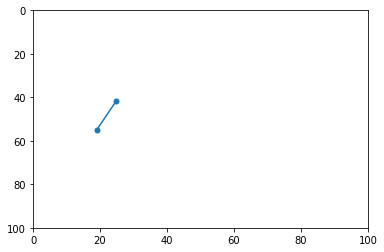

In [ ]:
sample_num = 30
x = [val_y[sample_num][0]]
x.append(model.predict(val_x)[sample_num][0])
y = [val_y[sample_num][1]]
y.append(model.predict(val_x)[sample_num][1])
plt.xlim(0, 100)
plt.ylim(100, 0)
plt.plot(x, y, marker="o", markersize=5)

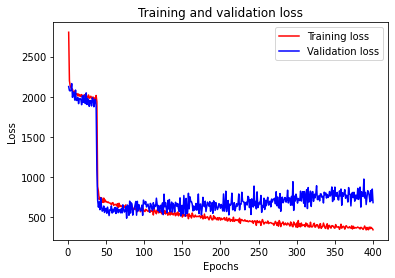

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

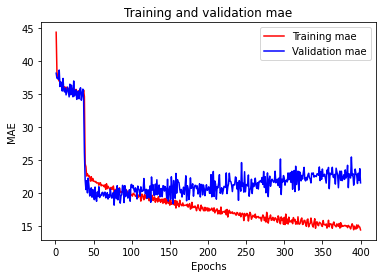

In [ ]:
plt.clf()
acc = history_dict["mae"]
val_acc = history_dict["val_mae"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Issues/Concerns

**After normalizing val_x:** Validation mae oftems gets to values less than training mae itself

**For trials using the shuffled val_x and val_y:** (Not Overfitting?) Graph indicates that validation data may be leaking into training data somewhere. Since the calibration points are being included in the training dataset for this model, another possibility is that the model is learning to find which calibration point a point is closest to and then give that calibration point as the prediction. This would give it a high mae since many calibration points have similar encoded face values and iris coordinates meaning that even with shuffling, the model would have seen many inputs that were similar to the validation data beforehand